In [1]:
#ignore if not windows
import winsound

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [37]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [38]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
nominal_sample = nominal_sample.sample(frac=failure_sample.shape[0]/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample])

In [39]:
feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [53]:
feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [54]:
y_curr = data_curr['failure']
x_curr = data_curr[feature_columns]
x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=0.8, random_state=1)

x_train = x_train.values
x_val = x_val.values
y_train = y_train.values
y_val = y_val.values

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [55]:
# *** MODELS ***
lr1 = LogisticRegression(solver='newton-cg')
lr2 = LogisticRegression(solver='lbfgs')
lr3 = LogisticRegression(solver='saga')
lr4 = LogisticRegression(solver='sag')
lr5 = LogisticRegression(solver='liblinear')

svm_linear = svm.SVC(kernel='linear', gamma='scale', probability=True)
svm_rbf = svm.SVC(kernel='rbf', gamma='scale', probability=True)
svm_poly = svm.SVC(kernel='poly', gamma='scale', probability=True)
svm_sig = svm.SVC(kernel='sigmoid', gamma='scale', probability=True)

rfc = RandomForestClassifier()
rfc100 = RandomForestClassifier(n_estimators=100)

boost1 = GradientBoostingClassifier(loss='deviance')
boost2 = GradientBoostingClassifier(loss='exponential')

gnb = GaussianNB()
ada = AdaBoostClassifier(gnb, algorithm="SAMME", n_estimators=200,learning_rate=.1)

In [56]:
model_results = {}
#models = [lr1, lr2, lr3, lr4, lr5, svm_linear, svm_poly, rfc, rfc100, boost1, boost2, gnb, ada]
models = [lr1, svm_poly, svm_linear, rfc, rfc100, boost1, boost2, gnb, ada]

In [57]:
# *** RUN MODELS ***

for model in models:

    model.fit(x_train, y_train)

    pred_train = model.predict_proba(x_train)[:,1]
    pred_val = model.predict_proba(x_val)[:,1]
    
    eval_v = helper.evaluation_metrics(pred_val, y_val)
    eval_t = helper.evaluation_metrics(pred_train, y_train)
    model_results[model] = {}
    model_results[model]['train'] = eval_t
    model_results[model]['val'] = eval_v
    
# *** RUN MODELS ***

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [58]:
winsound.MessageBeep()

In [59]:
models_plot = [lr1, rfc, svm_poly, boost2, gnb, ada]

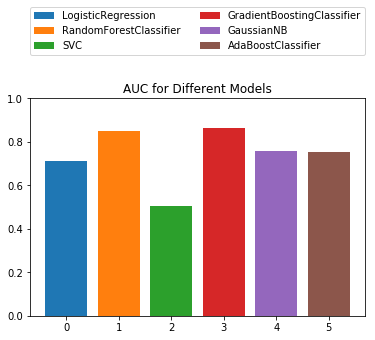

In [60]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

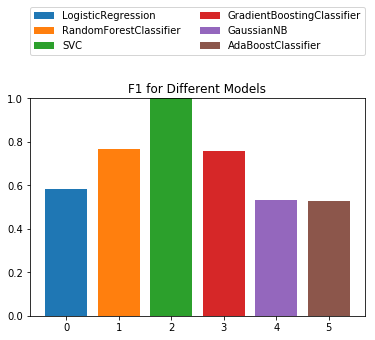

In [61]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

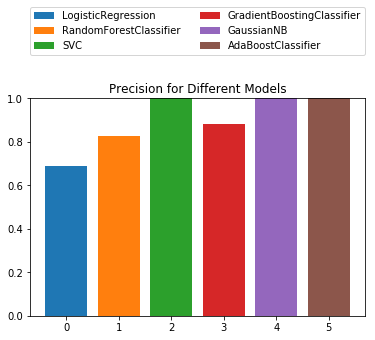

In [62]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

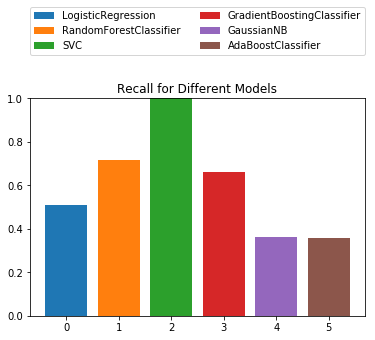

In [63]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

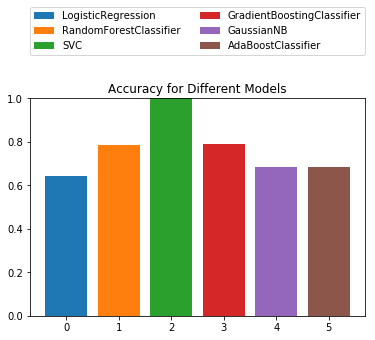

In [64]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

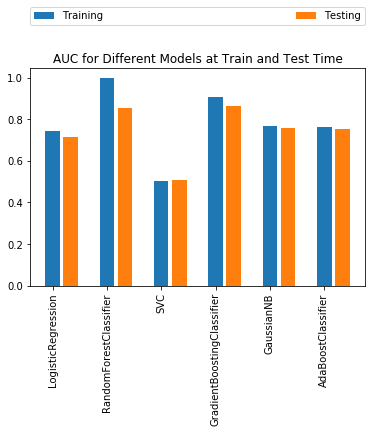

In [65]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.show()

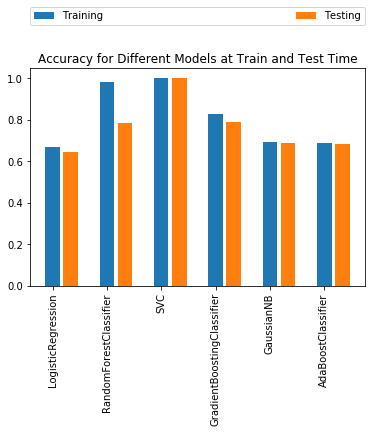

In [66]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.show()

In [19]:
0/0

ZeroDivisionError: division by zero

In [ ]:
# *** SPECIAL MODEL: xgboost ***
from xgboost import XGBClassifier

xgb = XGBClassifier(objective ='reg:linear', 
                             max_depth = 10,
                             silent = 1,
                             learning_rate = 0.05,
                             n_estimators = 1000)

eval_set = [(x_val, y_val)]

#TODO eval set should be sepearte from Test set!!!

xgb.fit(x_train, y_train, early_stopping_rounds=100,eval_metric= 'logloss', eval_set=eval_set)

pred_train = model.predict_proba(x_train)[:,1]
pred_val = model.predict_proba(x_val)[:,1]

# pred_future = svm_linear.predict_proba(x_future)[:,1]
# pred_train

eval = evaluation_metrics(pred_val, y_val)
print("Trained:  ", model)
print("Precision:", eval['precision'])
print("Recall:   ", eval['recall'])
print("Accuracy: ", eval['accuracy'])
print("F1-Score: ", eval['f1'])
print("AuC:      ", eval['roc_auc'])
print("")

# *** SPECIAL MODEL: xgboost ***

In [ ]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, mean_absolute_error,accuracy_score
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(x_curr, y_curr, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
eval_set = lgb.Dataset(X_val, label=y_val)
param = {'objective':'binary'}
train_data = lgb.Dataset(X_train, label=y_train, params=param)

num_round = 10
bst = lgb.train(params=param, train_set=train_data, num_boost_round=10, valid_sets=[eval_set])
y_pred = bst.predict(X_test)>.5
print("Classification Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy",accuracy)

In [ ]:
nominal_sample.groupby('model').date.count()